# **Team Let Us Talk Final Notebook**

* #### **We used Twitter Setiment Analysis Dataset from kaggle <https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset>**

## **OUR FULL PIPELINE**
![Alt text](pipeline.drawio.png "PIPELINE")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# WordCloud
from wordcloud import WordCloud

# Deep Learning / Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import gensim.downloader as gensim_api
import pickle  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91878\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91878\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91878\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **1) LOAD & COMBINE DATASETS**

In [2]:
train_data = pd.read_csv("data/train.csv", encoding='latin1')
test_data  = pd.read_csv("data/test.csv",  encoding='latin1')
df_full = pd.concat([train_data, test_data], ignore_index=True)

### **2) KEEP ONLY text & sentiment**

In [3]:
df = df_full[['text','sentiment']].copy()

### **3) DROP ROWS WITH MISSING text OR sentiment**

In [4]:
df.dropna(subset=['text','sentiment'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)
df.reset_index(drop=True, inplace=True)

### **4) MAP SENTIMENT STRINGS TO 0, 1, 2**

In [5]:
sentiment_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}
df['sentiment_mapped'] = df['sentiment'].map(sentiment_map)

before_drop = len(df)
df = df.dropna(subset=['sentiment_mapped'])
df.reset_index(drop=True, inplace=True)
after_drop = len(df)

df['sentiment_mapped'] = df['sentiment_mapped'].astype(int)

### **5) ADVANCED TEXT CLEANING**

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_text_cleaning(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove user mentions, hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation / non-alphanumeric
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = text.split()
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(advanced_text_cleaning)


### **6) EDA & VISUALIZATIONS**

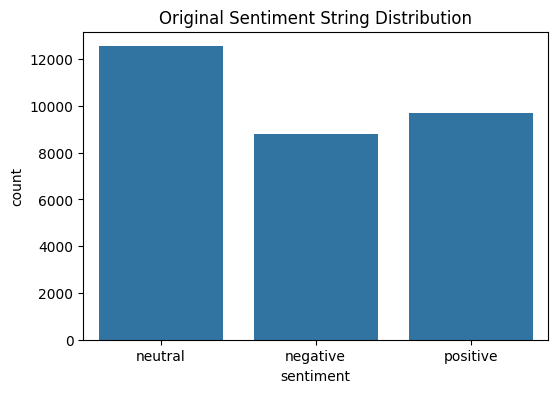

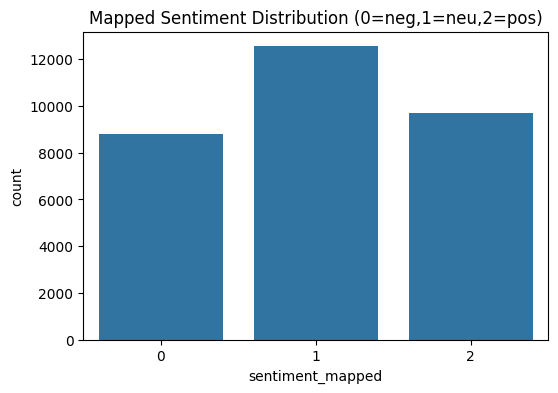


Counts:
sentiment_mapped
1    12547
2     9685
0     8782
Name: count, dtype: int64


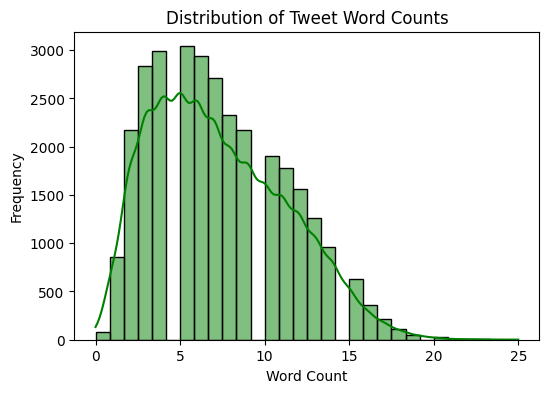

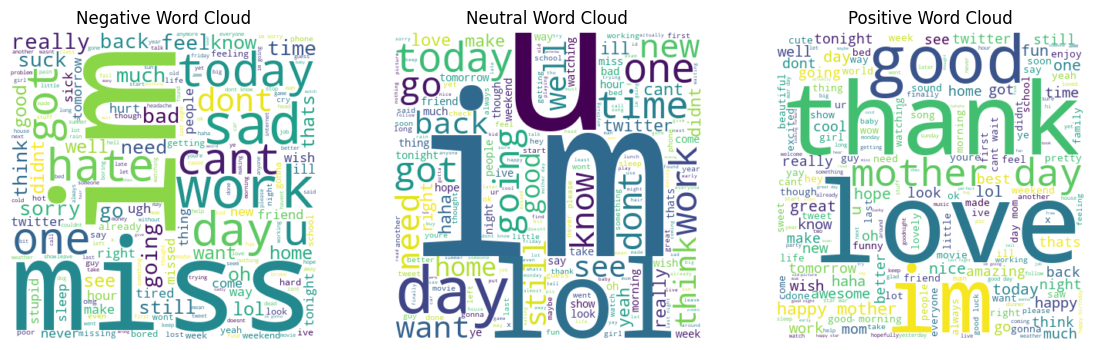

In [7]:
# (A) Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment')
plt.title("Original Sentiment String Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment_mapped')
plt.title("Mapped Sentiment Distribution (0=neg,1=neu,2=pos)")
plt.show()

print("\nCounts:")
print(df['sentiment_mapped'].value_counts())

# (B) Text Length Distribution
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=30, kde=True, color='green')
plt.title("Distribution of Tweet Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# (C) Word Clouds (with checks)
neg_text = " ".join(df.loc[df['sentiment_mapped']==0, 'clean_text'])
neu_text = " ".join(df.loc[df['sentiment_mapped']==1, 'clean_text'])
pos_text = " ".join(df.loc[df['sentiment_mapped']==2, 'clean_text'])

def plot_wordcloud(text_data, title="Word Cloud"):
    if not text_data.strip():
        print(f"No data for {title} (no matching rows). Skipping.")
        return
    wc = WordCloud(width=400, height=400, background_color='white').generate(text_data)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plot_wordcloud(neg_text, "Negative Word Cloud")
plt.subplot(1,3,2)
plot_wordcloud(neu_text, "Neutral Word Cloud")
plt.subplot(1,3,3)
plot_wordcloud(pos_text, "Positive Word Cloud")
plt.show()


### **7) TRAIN-TEST SPLIT**

In [8]:
X = df['clean_text']
y = df['sentiment_mapped']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### **8) FEATURE EXTRACTION**

In [9]:
# (A) BAG-OF-WORDS
bow_vectorizer = CountVectorizer(max_features=10000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

# (B) TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# (C) PRETRAINED WORD2VEC
print("\nLoading Pretrained Word2Vec Model (Google News)...")
try:
    w2v_model = gensim_api.load("word2vec-google-news-300")  # ~1.6GB
    print("Google News Word2Vec loaded successfully.")
except Exception as e:
    print("Error loading 'word2vec-google-news-300'. Consider using a smaller model.")
    raise e

def text_to_w2v(text):
    tokens = text.split()
    vectors = []
    for t in tokens:
        if t in w2v_model.key_to_index:
            vectors.append(w2v_model[t])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300, dtype='float32')

def get_w2v_embeddings(text_series):
    return np.vstack(text_series.apply(text_to_w2v).values)

X_train_w2v = get_w2v_embeddings(X_train)
X_test_w2v  = get_w2v_embeddings(X_test)

print("Shapes:")
print("BOW   :", X_train_bow.shape,  "->", X_test_bow.shape)
print("TF-IDF:", X_train_tfidf.shape,"->", X_test_tfidf.shape)
print("W2V   :", X_train_w2v.shape,  "->", X_test_w2v.shape)



Loading Pretrained Word2Vec Model (Google News)...
Google News Word2Vec loaded successfully.
Shapes:
BOW   : (24811, 10000) -> (6203, 10000)
TF-IDF: (24811, 10000) -> (6203, 10000)
W2V   : (24811, 300) -> (6203, 300)


### **9) 3D PCA VISUALIZATION ON TF-IDF & WORD2VEC**

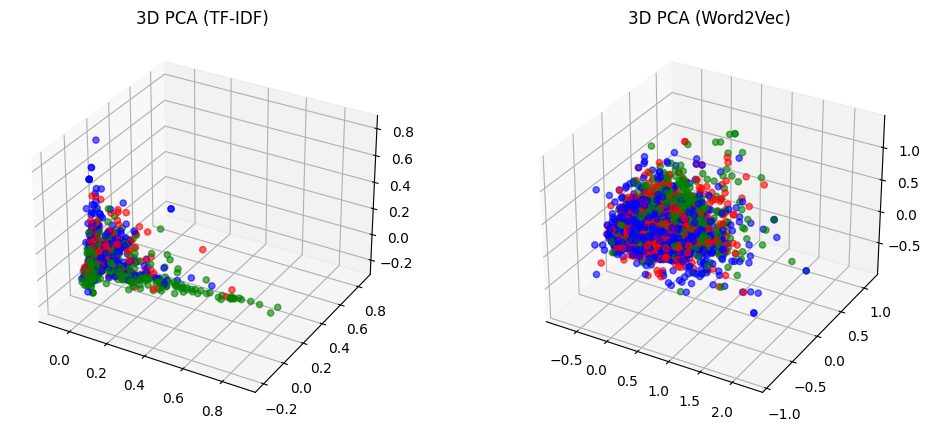

In [11]:
from mpl_toolkits.mplot3d import Axes3D

N_SAMPLES = 3000
if X_train_tfidf.shape[0] > N_SAMPLES:
    X_tfidf_samp = X_train_tfidf[:N_SAMPLES]
    y_samp       = y_train[:N_SAMPLES]
    X_w2v_samp   = X_train_w2v[:N_SAMPLES]
else:
    X_tfidf_samp = X_train_tfidf
    y_samp       = y_train
    X_w2v_samp   = X_train_w2v

pca_tfidf = PCA(n_components=3, random_state=42)
pca_w2v   = PCA(n_components=3, random_state=42)

X_tfidf_3d = pca_tfidf.fit_transform(X_tfidf_samp.toarray())
X_w2v_3d   = pca_w2v.fit_transform(X_w2v_samp)

fig = plt.figure(figsize=(12,5))

# TF-IDF
ax = fig.add_subplot(1,2,1, projection='3d')
colors = {0:'red', 1:'blue', 2:'green'}
color_vals = [colors[val] for val in y_samp]
ax.scatter(X_tfidf_3d[:,0], X_tfidf_3d[:,1], X_tfidf_3d[:,2], c=color_vals, alpha=0.6)
ax.set_title("3D PCA (TF-IDF)")

# Word2Vec
ax = fig.add_subplot(1,2,2, projection='3d')
color_vals = [colors[val] for val in y_samp]
ax.scatter(X_w2v_3d[:,0], X_w2v_3d[:,1], X_w2v_3d[:,2], c=color_vals, alpha=0.6)
ax.set_title("3D PCA (Word2Vec)")

plt.show()


### **10) BASELINE ML MODELS (BOW / TF-IDF / W2V)**

In [14]:

def train_and_eval(model, X_tr, X_te, y_tr, y_te, model_name):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    print(f"{model_name} Accuracy = {acc:.4f}")
    print(classification_report(y_te, preds))
    ConfusionMatrixDisplay.from_predictions(y_te, preds)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    return acc

baseline_acc = y_test.value_counts(normalize=True).max()

* ### **Logistic Regression**


-- Logistic Regression (BOW) --
LR-BOW Accuracy = 0.6942
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1756
           1       0.64      0.72      0.67      2510
           2       0.76      0.73      0.74      1937

    accuracy                           0.69      6203
   macro avg       0.71      0.69      0.70      6203
weighted avg       0.70      0.69      0.69      6203



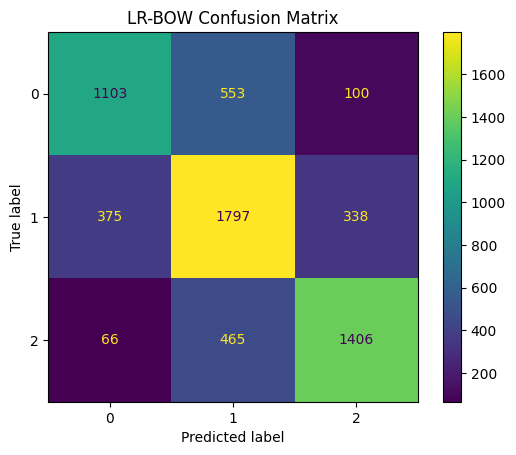


-- Logistic Regression (TF-IDF) --
LR-TFIDF Accuracy = 0.6911
              precision    recall  f1-score   support

           0       0.73      0.61      0.66      1756
           1       0.63      0.74      0.68      2510
           2       0.77      0.70      0.74      1937

    accuracy                           0.69      6203
   macro avg       0.71      0.68      0.69      6203
weighted avg       0.70      0.69      0.69      6203



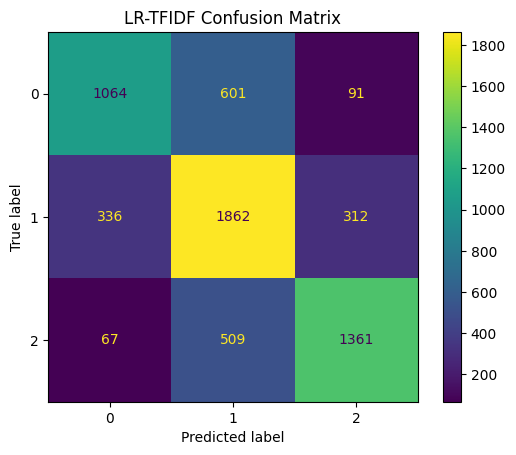


-- Logistic Regression (W2V) --
LR-W2V Accuracy = 0.6644
              precision    recall  f1-score   support

           0       0.70      0.58      0.63      1756
           1       0.60      0.73      0.66      2510
           2       0.74      0.66      0.70      1937

    accuracy                           0.66      6203
   macro avg       0.68      0.66      0.66      6203
weighted avg       0.67      0.66      0.66      6203



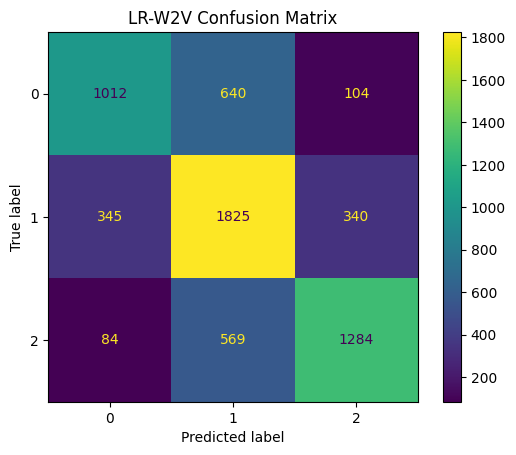

In [ ]:
lr = LogisticRegression(n_jobs=-1, max_iter=200)

print("\n-- Logistic Regression (BOW) --")
lr_bow_acc = train_and_eval(lr, X_train_bow, X_test_bow, y_train, y_test, "LR-BOW")

print("\n-- Logistic Regression (TF-IDF) --")
lr_tfidf_acc = train_and_eval(lr, X_train_tfidf, X_test_tfidf, y_train, y_test, "LR-TFIDF")

print("\n-- Logistic Regression (W2V) --")
lr_w2v_acc = train_and_eval(lr, X_train_w2v, X_test_w2v, y_train, y_test, "LR-W2V")

* ### **Decision Tree**


-- Decision Tree (BOW) --
DT-BOW Accuracy = 0.6494
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1756
           1       0.63      0.63      0.63      2510
           2       0.70      0.69      0.70      1937

    accuracy                           0.65      6203
   macro avg       0.65      0.65      0.65      6203
weighted avg       0.65      0.65      0.65      6203



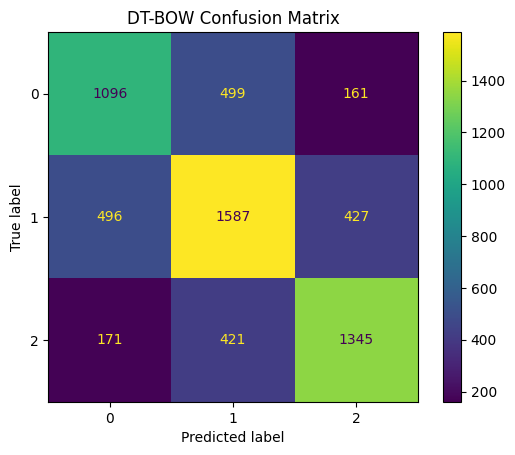


-- Decision Tree (TF-IDF) --
DT-TFIDF Accuracy = 0.6513
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1756
           1       0.64      0.63      0.63      2510
           2       0.68      0.71      0.70      1937

    accuracy                           0.65      6203
   macro avg       0.65      0.65      0.65      6203
weighted avg       0.65      0.65      0.65      6203



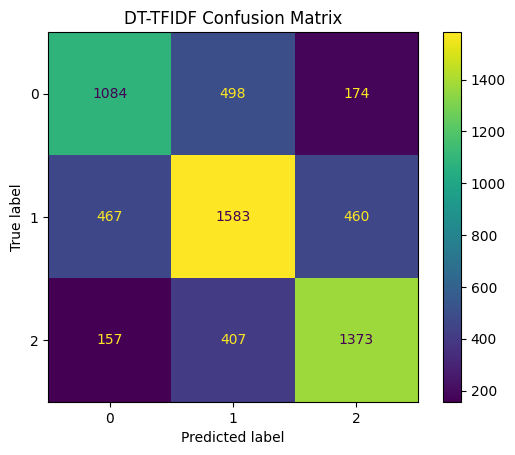


-- Decision Tree (W2V) --
DT-W2V Accuracy = 0.4762
              precision    recall  f1-score   support

           0       0.43      0.44      0.43      1756
           1       0.49      0.48      0.48      2510
           2       0.50      0.51      0.51      1937

    accuracy                           0.48      6203
   macro avg       0.47      0.48      0.47      6203
weighted avg       0.48      0.48      0.48      6203



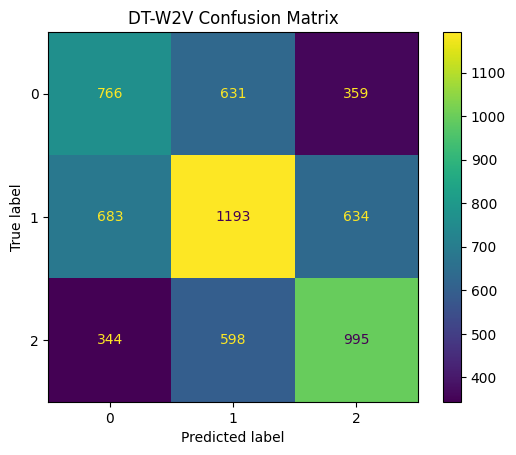

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
print("\n-- Decision Tree (BOW) --")
dt_bow_acc = train_and_eval(dt, X_train_bow, X_test_bow, y_train, y_test, "DT-BOW")

print("\n-- Decision Tree (TF-IDF) --")
dt_tfidf_acc = train_and_eval(dt, X_train_tfidf, X_test_tfidf, y_train, y_test, "DT-TFIDF")

print("\n-- Decision Tree (W2V) --")
dt_w2v_acc = train_and_eval(dt, X_train_w2v, X_test_w2v, y_train, y_test, "DT-W2V")

* ### **Random Forest**


-- Random Forest (BOW) --
RF-BOW Accuracy = 0.6905
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1756
           1       0.66      0.69      0.67      2510
           2       0.73      0.75      0.74      1937

    accuracy                           0.69      6203
   macro avg       0.70      0.69      0.69      6203
weighted avg       0.69      0.69      0.69      6203



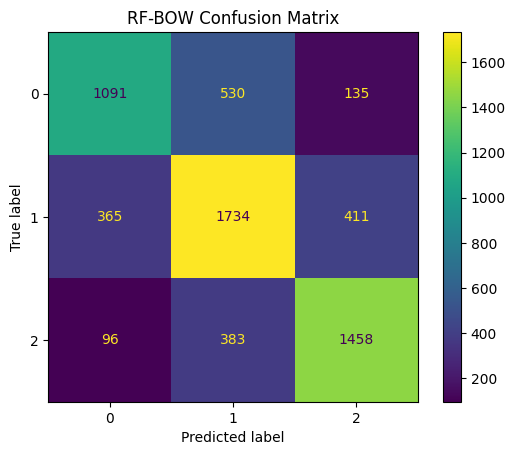


-- Random Forest (TF-IDF) --
RF-TFIDF Accuracy = 0.6989
              precision    recall  f1-score   support

           0       0.72      0.62      0.67      1756
           1       0.66      0.72      0.69      2510
           2       0.75      0.75      0.75      1937

    accuracy                           0.70      6203
   macro avg       0.71      0.69      0.70      6203
weighted avg       0.70      0.70      0.70      6203



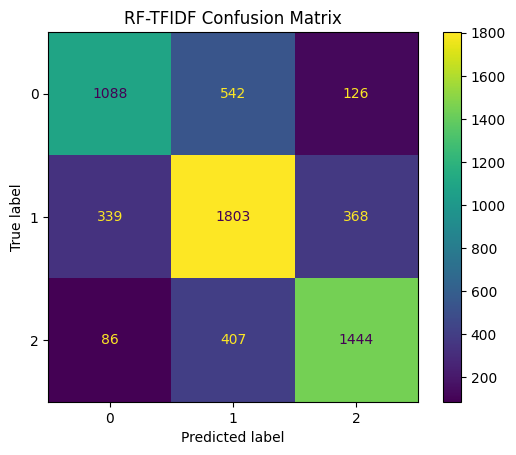


-- Random Forest (W2V) --
RF-W2V Accuracy = 0.6223
              precision    recall  f1-score   support

           0       0.68      0.46      0.55      1756
           1       0.55      0.77      0.64      2510
           2       0.74      0.58      0.65      1937

    accuracy                           0.62      6203
   macro avg       0.66      0.60      0.61      6203
weighted avg       0.65      0.62      0.62      6203



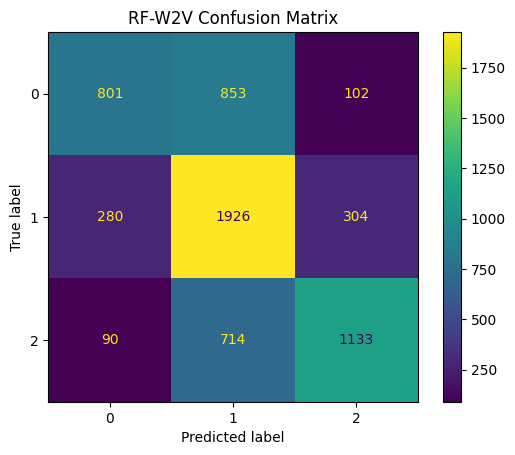

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
print("\n-- Random Forest (BOW) --")
rfc_bow_acc = train_and_eval(rfc, X_train_bow, X_test_bow, y_train, y_test, "RF-BOW")

print("\n-- Random Forest (TF-IDF) --")
rfc_tfidf_acc = train_and_eval(rfc, X_train_tfidf, X_test_tfidf, y_train, y_test, "RF-TFIDF")

print("\n-- Random Forest (W2V) --")
rfc_w2v_acc = train_and_eval(rfc, X_train_w2v, X_test_w2v, y_train, y_test, "RF-W2V")

### **11) DEEP LEARNING MODELS**

In [26]:
VOCAB_SIZE = 20000
MAX_LENGTH = 50

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences  = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded  = pad_sequences(test_sequences,  maxlen=MAX_LENGTH, padding='post', truncating='post')

y_train_dl = np.array(y_train)
y_test_dl  = np.array(y_test)

### **(A) LSTM**

In [27]:
lstm_model = models.Sequential()
lstm_model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_LENGTH))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n=== LSTM Model Summary ===")
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train_padded, y_train_dl,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

lstm_loss, lstm_acc = lstm_model.evaluate(X_test_padded, y_test_dl, verbose=0)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")


=== LSTM Model Summary ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.4036 - loss: 1.0896 - val_accuracy: 0.3971 - val_loss: 1.0893
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.4052 - loss: 1.0874 - val_accuracy: 0.3971 - val_loss: 1.0896
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.4084 - loss: 1.0867 - val_accuracy: 0.3971 - val_loss: 1.0890
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.3991 - loss: 1.0888 - val_accuracy: 0.3971 - val_loss: 1.0900
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.4131 - loss: 1.0846 - val_accuracy: 0.3971 - val_loss: 1.0888
LSTM Test Accuracy: 0.4046


### **(B) BiLSTM**

In [28]:
bilstm_model = models.Sequential()
bilstm_model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_LENGTH))
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
bilstm_model.add(Dense(128, activation='relu'))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(3, activation='softmax'))

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n=== BiLSTM Model Summary ===")
bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train_padded, y_train_dl,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test_padded, y_test_dl, verbose=0)
print(f"BiLSTM Test Accuracy: {bilstm_acc:.4f}")


=== BiLSTM Model Summary ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.4996 - loss: 0.9795 - val_accuracy: 0.6921 - val_loss: 0.7219
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.7866 - loss: 0.5538 - val_accuracy: 0.6879 - val_loss: 0.7505
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8591 - loss: 0.3888 - val_accuracy: 0.6873 - val_loss: 0.8318
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.8965 - loss: 0.2904 - val_accuracy: 0.6774 - val_loss: 0.9244
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.9280 - loss: 0.2181 - val_accuracy: 0.6708 - val_loss: 1.0868
BiLSTM Test Accuracy: 0.6673


### **(C) BiLSTM + Attention**

* I changed the hyperparameters by learning from the previous results

In [34]:
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight", shape=(input_shape[-1], 1),
            initializer="normal", trainable=True
        )
        self.b = self.add_weight(
            name="att_bias", shape=(input_shape[1], 1),
            initializer="zeros", trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = tf.matmul(inputs, self.W)  
        e = tf.squeeze(e, -1)          
        e = e + tf.squeeze(self.b, -1) 
        alpha = tf.nn.softmax(e)       
        alpha = tf.expand_dims(alpha, axis=-1) 
        context = inputs * alpha       
        context = tf.reduce_sum(context, axis=1) 
        return context

bilstm_att_model = models.Sequential()
bilstm_att_model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_LENGTH))
bilstm_att_model.add(Bidirectional(LSTM(128, return_sequences=True)))
bilstm_att_model.add(AttentionLayer())
bilstm_att_model.add(Dense(128, activation='relu'))
bilstm_att_model.add(Dropout(0.3))
bilstm_att_model.add(Dense(3, activation='softmax'))

bilstm_att_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\n=== BiLSTM + Attention Model Summary ===")
bilstm_att_model.summary()

history_bilstm_att = bilstm_att_model.fit(
    X_train_padded, y_train_dl,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

bilstm_att_loss, bilstm_att_acc = bilstm_att_model.evaluate(X_test_padded, y_test_dl, verbose=0)
print(f"BiLSTM + Attention Test Accuracy: {bilstm_att_acc:.4f}")


=== BiLSTM + Attention Model Summary ===


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_2               │ ?                      │   0 (unbuilt) │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.4249 - loss: 1.0615 - val_accuracy: 0.6548 - val_loss: 0.8073
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.7338 - loss: 0.6621 - val_accuracy: 0.6957 - val_loss: 0.7285
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8295 - loss: 0.4530 - val_accuracy: 0.6960 - val_loss: 0.7804
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.8935 - loss: 0.3057 - val_accuracy: 0.6867 - val_loss: 0.8899
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9223 - loss: 0.2278 - val_accuracy: 0.6780 - val_loss: 0.9657
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9431 - loss: 0.1727 - val_accuracy: 0.6637 - val_loss: 1.0751
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9530 - loss: 0.1406 - val_accuracy: 0.6633 - val_loss: 1.1940
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9600 - loss: 0

* #### **Plotting Visualizations**

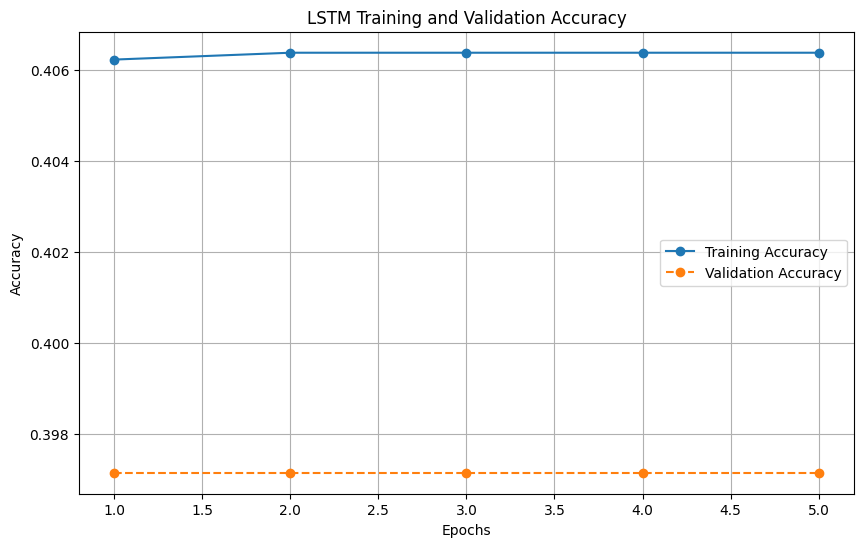

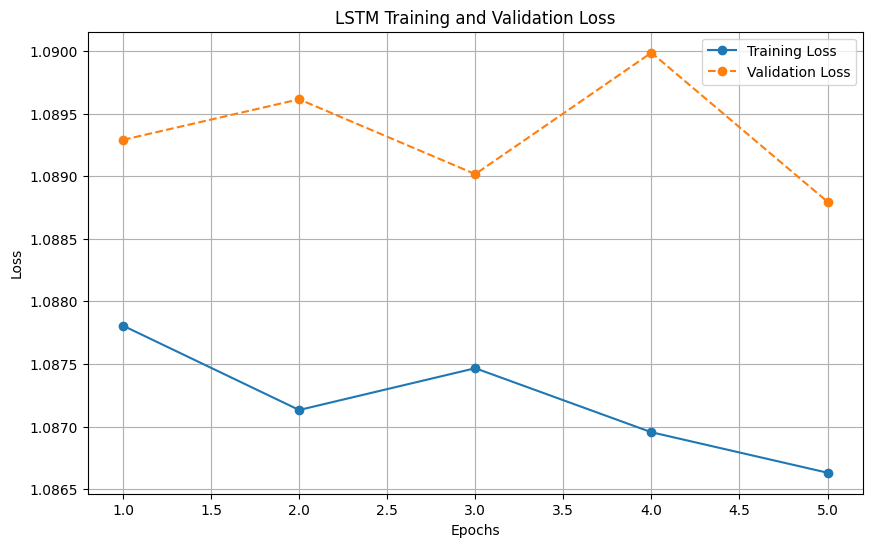

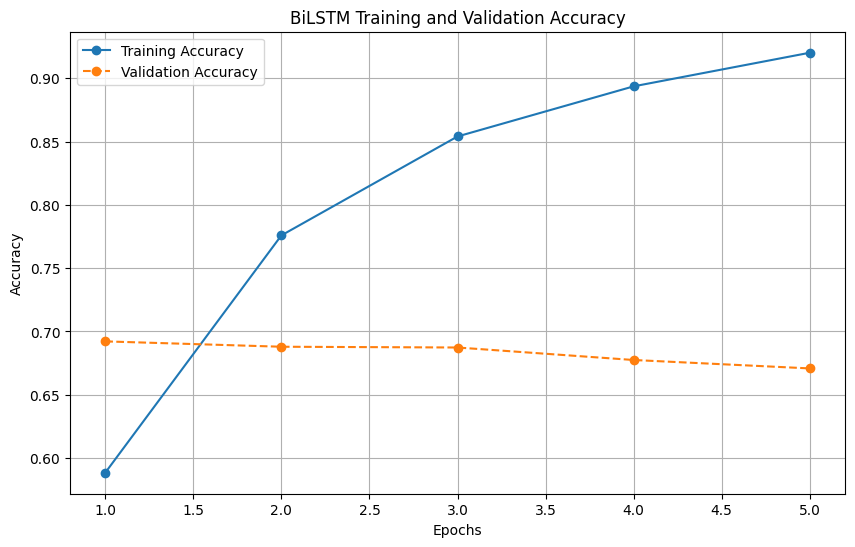

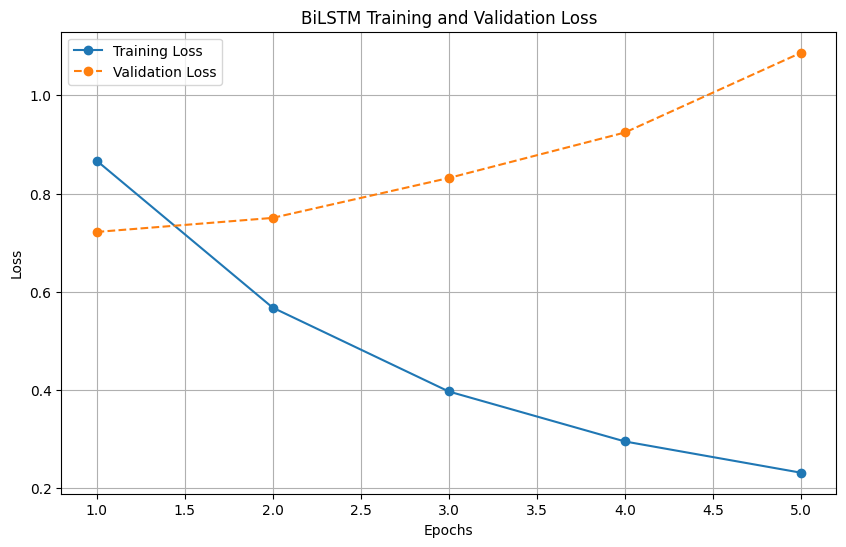

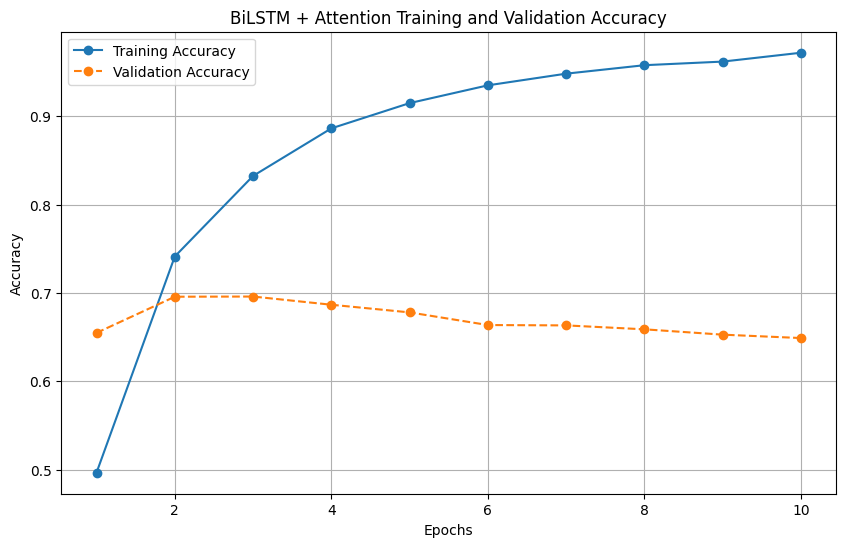

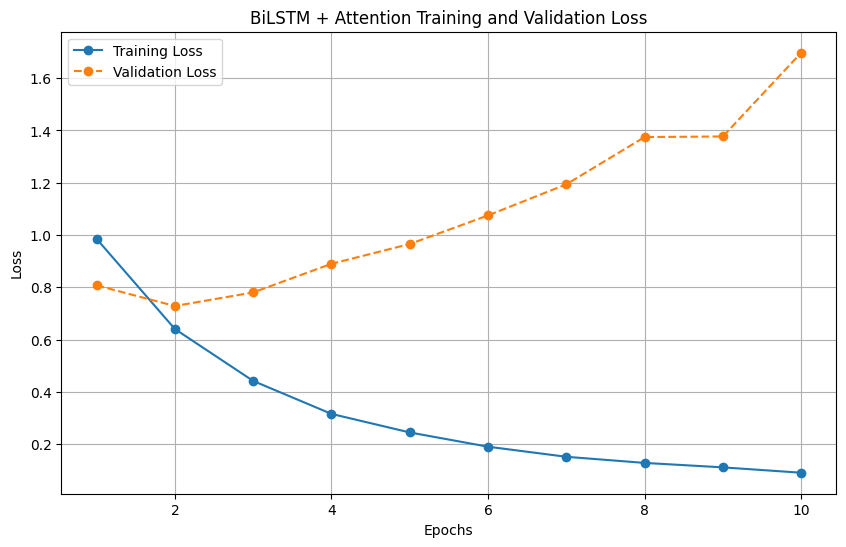

In [35]:
def plot_metrics(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--', marker='o')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--', marker='o')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(history_lstm, "LSTM")
plot_metrics(history_bilstm, "BiLSTM")
plot_metrics(history_bilstm_att, "BiLSTM + Attention")

### **12) COMPARE RESULTS**

In [36]:
print("\n===============================")
print("       FINAL ACCURACY SCORES  ")
print("===============================")
print(f"Baseline (Most Frequent): {baseline_acc:.4f}")

print("\n--- Logistic Regression ---")
print(f"BOW:    {lr_bow_acc:.4f}")
print(f"TF-IDF: {lr_tfidf_acc:.4f}")
print(f"W2V:    {lr_w2v_acc:.4f}")

print("\n--- Decision Tree ---")
print(f"BOW:    {dt_bow_acc:.4f}")
print(f"TF-IDF: {dt_tfidf_acc:.4f}")
print(f"W2V:    {dt_w2v_acc:.4f}")

print("\n--- Random Forest ---")
print(f"BOW:    {rfc_bow_acc:.4f}")
print(f"TF-IDF: {rfc_tfidf_acc:.4f}")
print(f"W2V:    {rfc_w2v_acc:.4f}")

print("\n--- Deep Learning Models ---")
print(f"LSTM:                {lstm_acc:.4f}")
print(f"BiLSTM:              {bilstm_acc:.4f}")
print(f"BiLSTM+Attention:    {bilstm_att_acc:.4f}")


       FINAL ACCURACY SCORES  
Baseline (Most Frequent): 0.4046

--- Logistic Regression ---
BOW:    0.6942
TF-IDF: 0.6911
W2V:    0.6644

--- Decision Tree ---
BOW:    0.6494
TF-IDF: 0.6513
W2V:    0.4762

--- Random Forest ---
BOW:    0.6905
TF-IDF: 0.6989
W2V:    0.6223

--- Deep Learning Models ---
LSTM:                0.4046
BiLSTM:              0.6673
BiLSTM+Attention:    0.6407


### **13) MANUAL TESTING FUNCTION**

In [37]:
def predict_sentiment_manual(text, model, tokenizer, max_length=50):
    cleaned = advanced_text_cleaning(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    proba = model.predict(padded)
    label = np.argmax(proba, axis=1)[0]  # 0,1,2
    mapping = {0:"negative", 1:"neutral", 2:"positive"}
    return mapping[label]

test_example = "I love this new phone. It's fantastic!"
predicted_sentiment = predict_sentiment_manual(test_example, bilstm_att_model, tokenizer, MAX_LENGTH)
print(f"\nManual Testing Example:")
print(f"Text: {test_example}")
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step

Manual Testing Example:
Text: I love this new phone. It's fantastic!
Predicted Sentiment: positive


### **SAVE THE TRAINED MODEL AND TOKENIZER**

In [38]:
print("\nSaving the BiLSTM+Attention model and tokenizer...")

# 1) Saving the Keras model 
bilstm_att_model.save("models/bilstm_att_model.h5")

# 2) Save the tokenizer using pickle
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully.")


Saving the BiLSTM+Attention model and tokenizer...
Model and tokenizer saved successfully.
